### Imports & constants

In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

import utils

In [2]:
TH12_PATH = os.path.join(os.curdir, 'datasets', 'TH12')
OUTPUT_PATH = os.path.join(os.curdir, 'output', 'TH12.npz')

### Data processing

In [3]:
imgs_s = [] # np.array with sagittal MIPs
imgs_f = [] # np.array with frontal MIPs
v_levels = [] # np.array with labels in mm
ids = [] # np.array with CTs identifiers
thicks = [] # np.array with CTs slices' thicknesses

In [4]:
label_paths = glob.glob(os.path.join(TH12_PATH, 'labels', '*.bmp')) # 3 imgs with segmented vertebraes per exam
ct_ids = [label_path.split('/')[-1][:3] for label_path in label_paths]

In [5]:
slices = {} # e.g. {'01A': 83, '54A': 87}
for ct_id in ct_ids:
    curr_label_paths = [label_path for label_path in label_paths if ct_id in label_path]
    curr_slices = sorted([int(label_path.split('/')[-1].split('.')[0][3:]) for label_path in curr_label_paths])
    slices[ct_id] = curr_slices[1]

In [15]:
subdirs = glob.glob(os.path.join(TH12_PATH, 'dicoms', '*', '*', '*'))

for subdir in subdirs:    
    ct_id = subdir.split('/')[-2]
    
    try:
        img, pixel_spacing, slice_thickness = utils.read_dicom(subdir)
    except ValueError as e:
        print(f'An exception for {subdir} occured: {str(e)}')
        continue

    label = slices[ct_id]
    label_mm = int(round(slices[ct_id] * slice_thickness))
    
    # converting to HU scale
    img = utils.to_HU(img)
    
    # mass center calculation + 0ing everything outside body 
    img, center_h, center_w = utils.get_mass_center(img)
    
    # frontal MIP 
    img_cropped = utils.crop_ct(img, center_h, center_w)
    img_mip_f = np.amax(img_cropped, axis=0)
    img_mip_f = np.swapaxes(img_mip_f, 0, 1)
    
    # rescaling to 1mm x 1mm
    img_mip_f = utils.rescale_mip(img_mip_f, pixel_spacing[0], slice_thickness)
    
    # sagittal MIP
    img_cropped = utils.crop_ct(img, center_h, center_w, for_frontal=False)
    img_mip_s = np.amax(img_cropped, axis=1) 
    img_mip_s = np.swapaxes(img_mip_s, 0, 1)
    
    # rescaling to 1mm x 1mm
    img_mip_s = utils.rescale_mip(img_mip_s, pixel_spacing[0], slice_thickness)
    
    # saving 
    imgs_s.append(img_mip_s)
    imgs_f.append(img_mip_f)
    v_levels.append([label_mm, -1])
    ids.append(ct_id)
    thicks.append(slice_thickness)

./datasets/TH12/dicoms/26SA/26A/Thorax  3.0  B20f_Series0002


In [ ]:
imgs_s = np.asarray(imgs_s)
imgs_f = np.asarray(imgs_f)
v_levels = np.asarray(v_levels)
ids = np.asarray(ids)
thicks = np.asarray(thicks)
n_mips = imgs_s.shape[0]

### Discarding corrupted examinations

In [20]:
import pycimg

26A


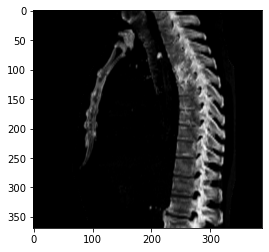

26B


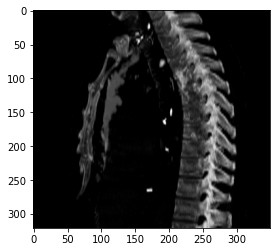

53B


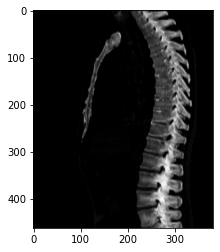

53A


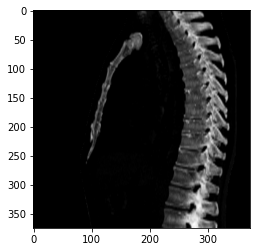

48A


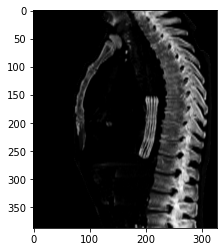

10B


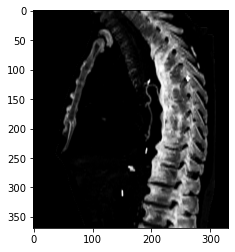

10A


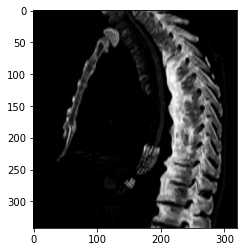

54A


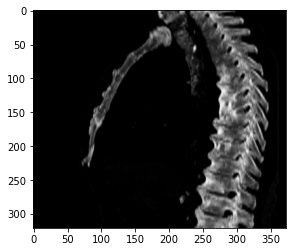

54B


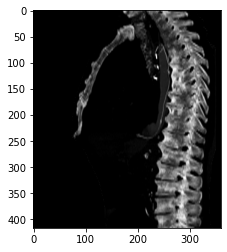

18A


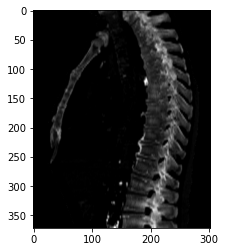

18B


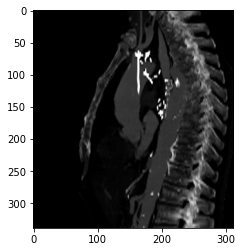

56A


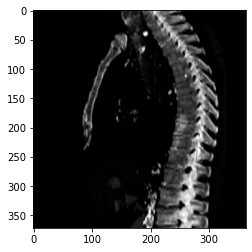

56B


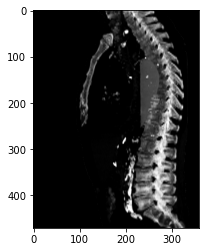

45A


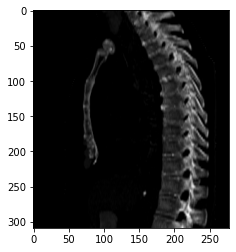

45B


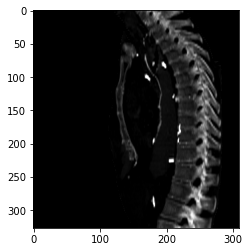

32B


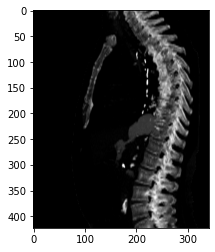

32A


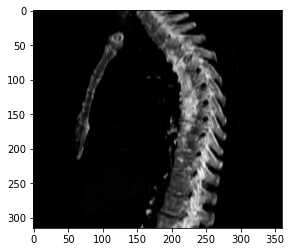

34A


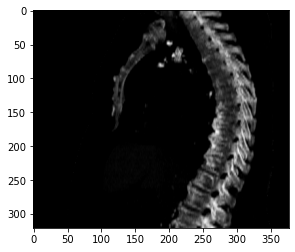

34B


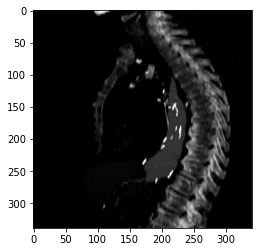

02A


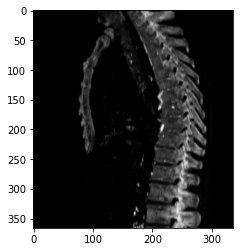

02B


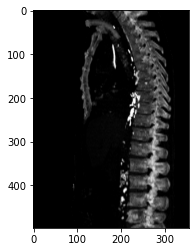

57A


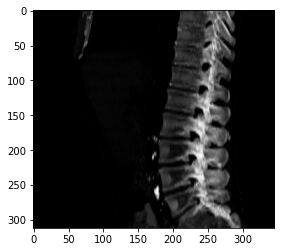

57B


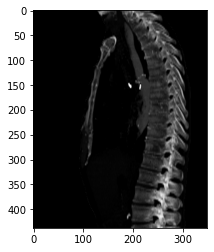

19B


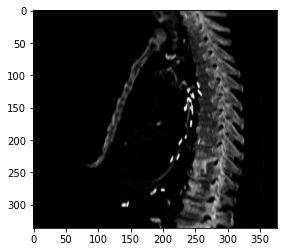

19A


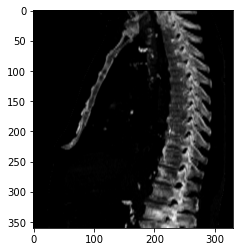

33B


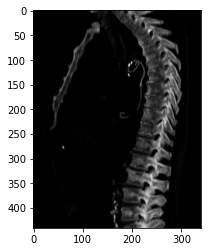

33A


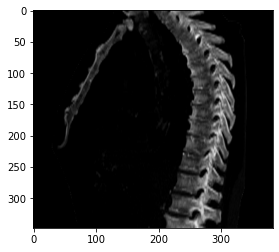

08B


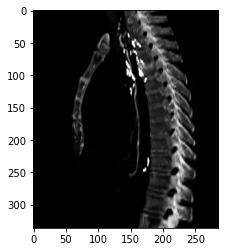

08A


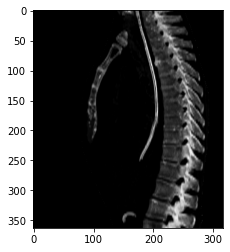

06B


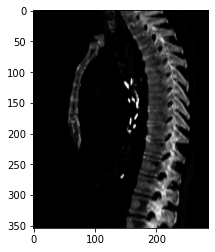

06A


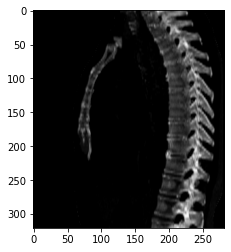

43A


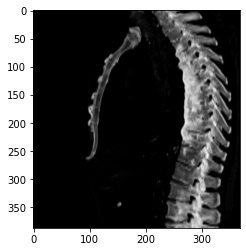

43B


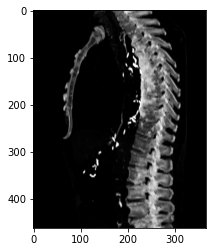

14B


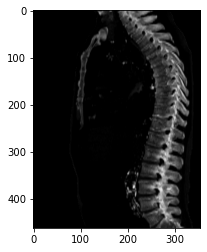

14A


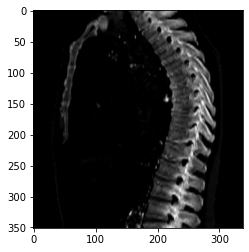

25A


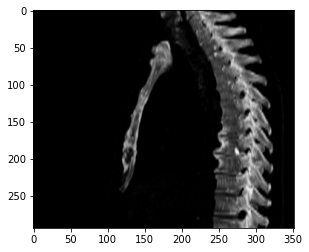

25B


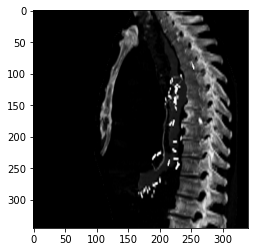

16B


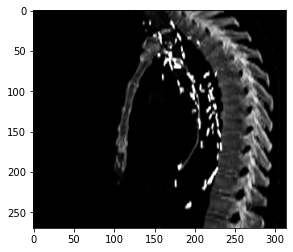

16A


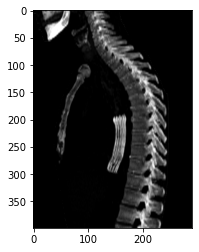

40B


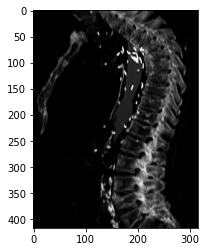

40A


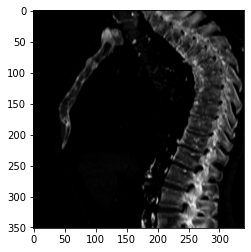

03B


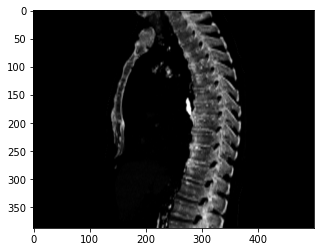

03A


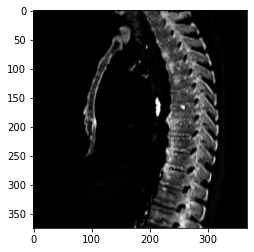

11B


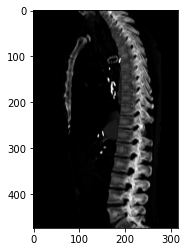

11A


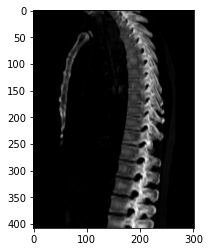

28B


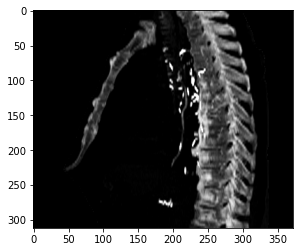

28A


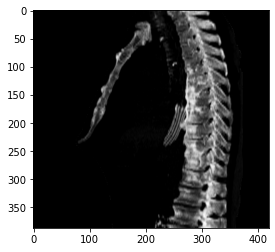

23A


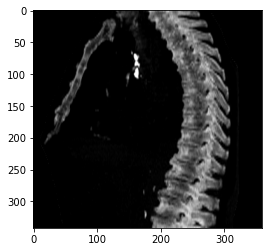

23B


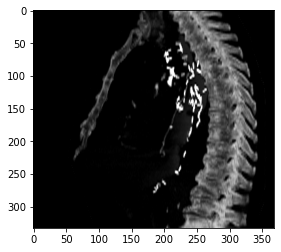

42A


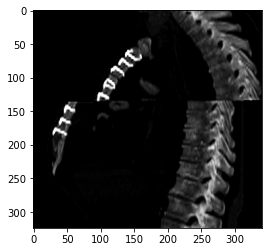

42B


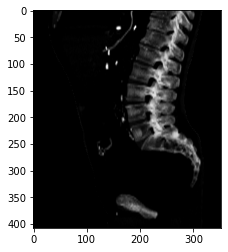

44B


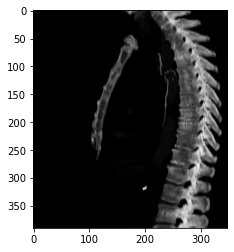

44A


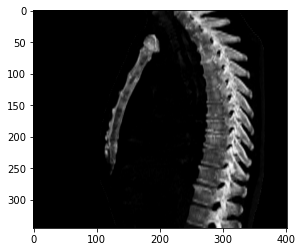

49A


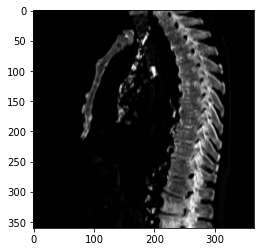

49B


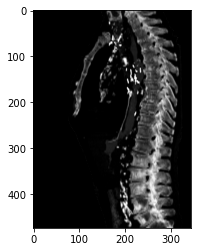

05A


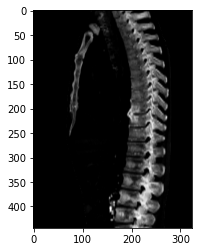

05B


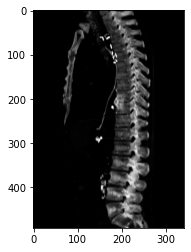

39B


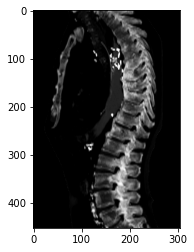

39A


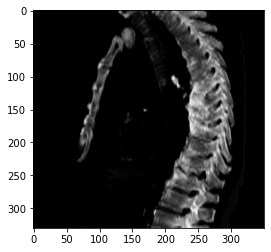

38B


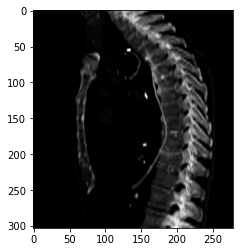

38A


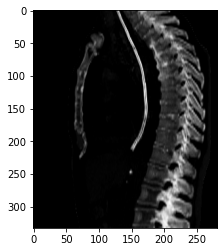

36B


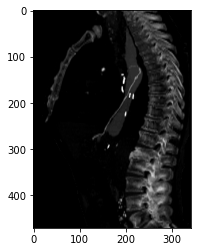

36A


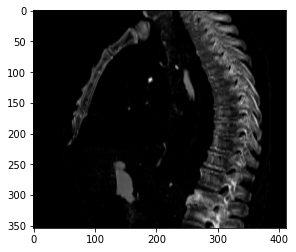

31B


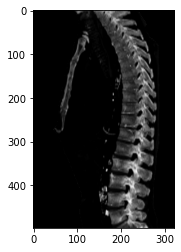

31A


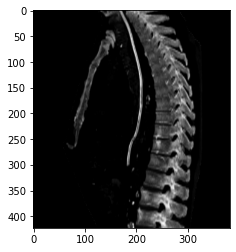

35A


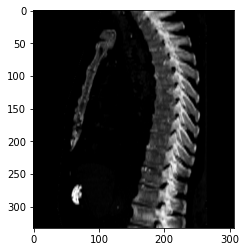

41A


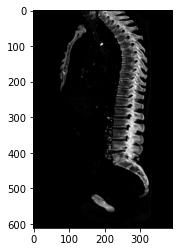

24A


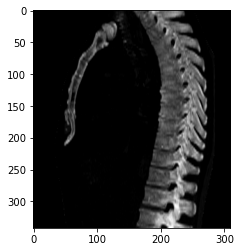

24B


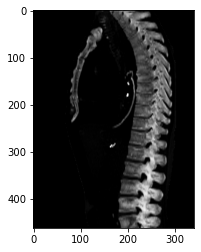

50A


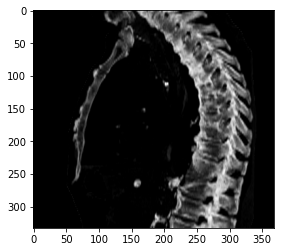

30A


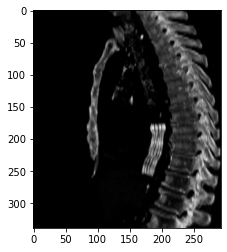

30B


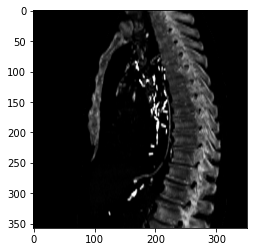

17B


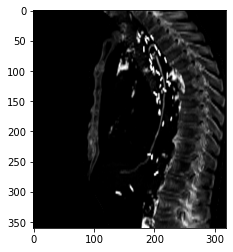

17A


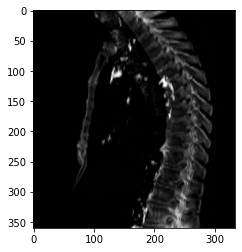

27B


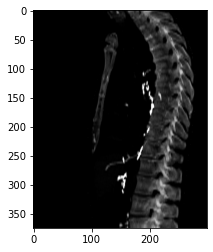

27A


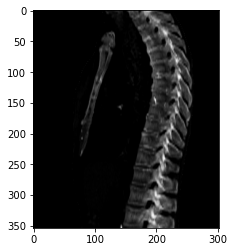

22A


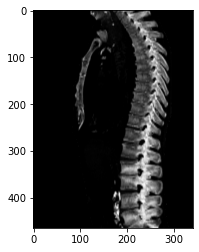

22B


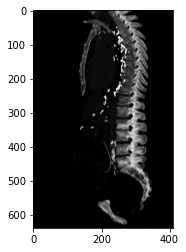

52A


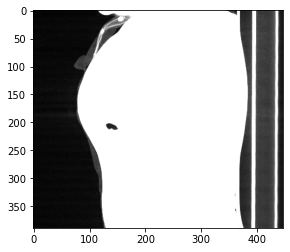

52B


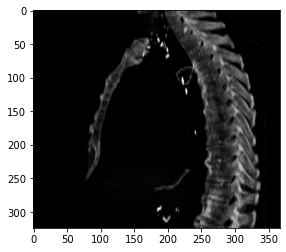

01B


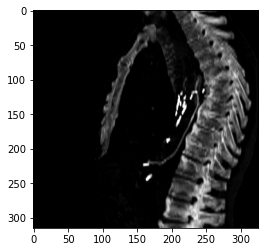

01A


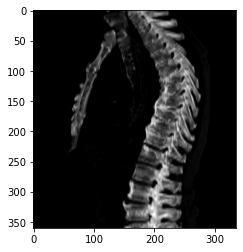

04A


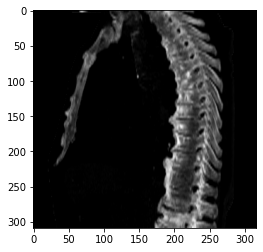

04B


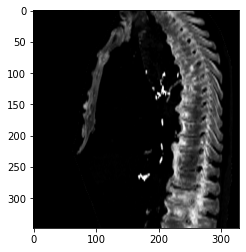

29A


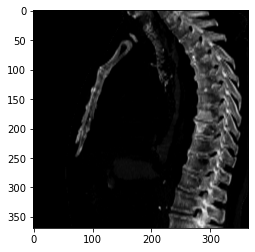

29B


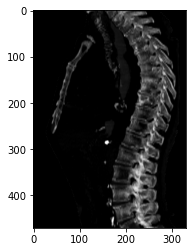

15B


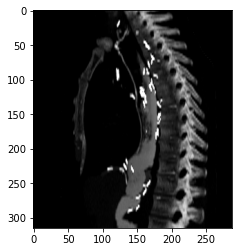

15A


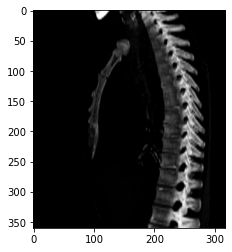

51A


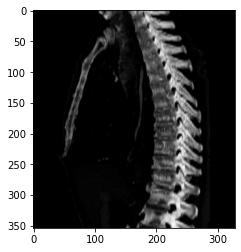

51B


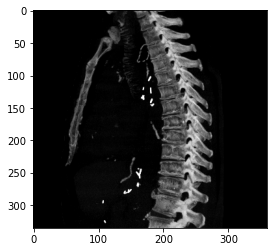

37A


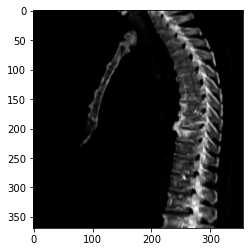

37B


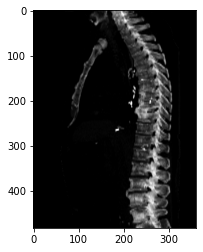

47A


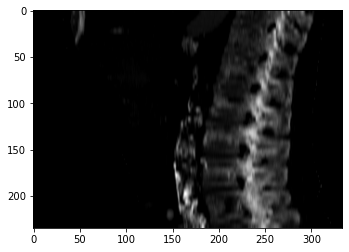

13A


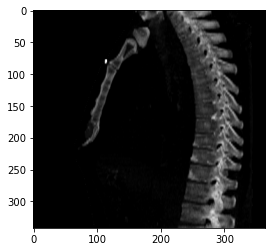

13B


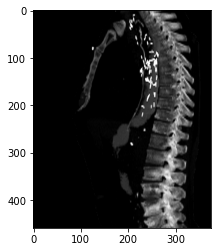

12A


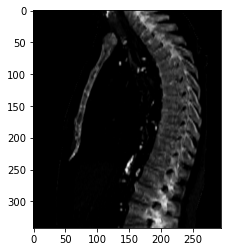

12B


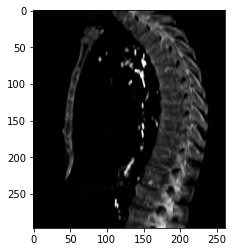

09B


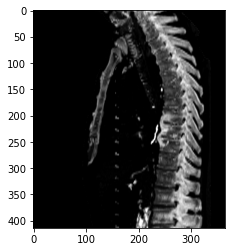

09A


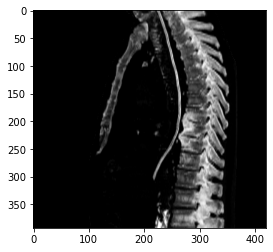

20A


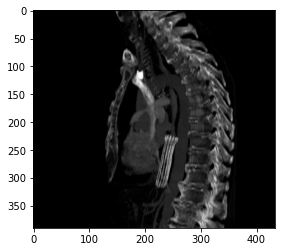

20B


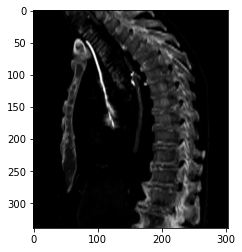

21B


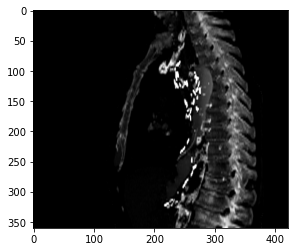

21A


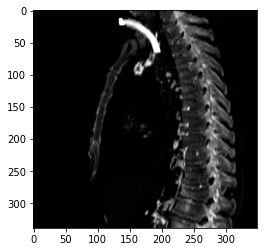

46B


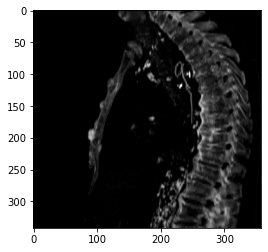

46A


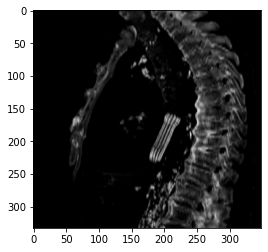

07A


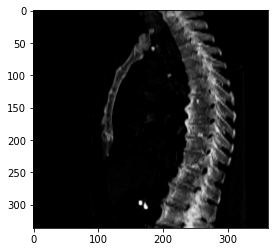

07B


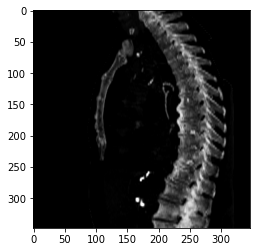

55A


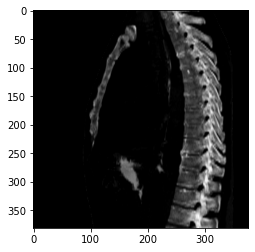

55B


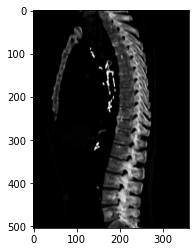

In [12]:
for i in range(imgs_s.shape[0]): # 42A, 52A corrupted
    print(ids[i])
    img = imgs_s[i]
    img = np.clip(img, 100, 1500)
    plt.imshow(img, cmap='gray')
    plt.show()

In [21]:
for subdir in subdirs:
    ct_id = subdir.split('/')[-2]
    if ct_id in ('42A', '52A'):
        img, pixel_spacing, slice_thickness = utils.read_dicom(subdir)
        label = slices[ct_id]
        label_mm = int(round(slices[ct_id] * slice_thickness))
    
        # converting to HU scale
        img = utils.to_HU(img)
    
        pycimg.CImg(img).display()

In [22]:
imgs_s = imgs_s[np.logical_and(ids != '42A', ids != '52A')]
imgs_f = imgs_f[np.logical_and(ids != '42A', ids != '52A')]
v_levels = v_levels[np.logical_and(ids != '42A', ids != '52A')]
thicks = thicks[np.logical_and(ids != '42A', ids != '52A')]
ids = ids[np.logical_and(ids != '42A', ids != '52A')]
n_mips = imgs_s.shape[0]

In [26]:
np.savez_compressed(OUTPUT_PATH, imgs_s=imgs_s, imgs_f=imgs_f,
                    v_levels=v_levels, ids=ids, thicks=thicks, n_mips=n_mips)